# Download Sentinel-1 RTC for each ASO raster
Given an ASO raster, find and download 1) the most proximate in time S1 RTC product 2) a "snow-off" RTC product from the preceeding summer. 

In [1]:
# based on exmaples from
# https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import glob
import rioxarray as rxr
import re
import datetime
import pandas as pd
from shapely.geometry import box
import odc.stac
import numpy as np

In [15]:
def RTC_for_aso_snowon(aso_raster_fn):
    
    time = pd.to_datetime(re.search("(\d{4}\d{2}\d{2})", aso_raster_fn).group())
    week_before = (time - datetime.timedelta(weeks=1)).strftime('%Y-%m-%d')
    week_after = (time + datetime.timedelta(weeks=1)).strftime('%Y-%m-%d')
    time_of_interest = f'{week_before}/{week_after}'
    
    aso_raster = rxr.open_rasterio(aso_raster_fn).squeeze()
    bounds_latlon = box(*aso_raster.rio.transform_bounds("EPSG:4326"))
    
    
    catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

    search = catalog.search(
        collections=["sentinel-1-rtc"],
        intersects=bounds_latlon,
        datetime=time_of_interest)

    # Check how many items were returned
    items = search.item_collection()
    print(f"Returned {len(items)} Items")
    
    rtc_stac = odc.stac.load(items,chunks={"x": 2048, "y": 2048},resolution=50, groupby='sat:absolute_orbit')
    rtc_stac_clipped = rtc_stac.rio.clip_box(*bounds_latlon.bounds,crs="EPSG:4326")
    
    # clip to ASO extent
    rtc_stac_clipped = rtc_stac_clipped.rio.reproject_match(aso_raster).where(aso_raster>=0)
    
    # limit to morning acquisitions
    rtc_ds = rtc_stac_clipped.where(rtc_stac_clipped.time.dt.hour > 11, drop=True)
    
    # calculate percent coverage of each acquisition
    perc_cover = (rtc_ds.vh > 0).sum(dim=['x', 'y'])/(rtc_ds.vh >= -1000000000).sum(dim=['x', 'y'])
    
    # if multiple with full coverage, grab nearest in time with full coverage
    if perc_cover.values.tolist().count(1) > 1:
        rtc_ds = rtc_ds.where(perc_cover == 1, drop=True).sortby('time')
        rtc_ds = rtc_ds.sel(time=time, method='nearest')
    
    # exit if no rasters have good vh coverage
    elif perc_cover.max() < 0.1:
        print('max vh coverage is < 10 percent--recommend skipping ASO raster')
        return None, None
     
    # otherwise, grab max coverage 
    else:
        rtc_ds = rtc_ds.sel(time=perc_cover.idxmax())
    
    return rtc_ds, aso_raster
    
#     idx_least_clouds = scl.where(scl.isin(classes)).sum(dim=['x','y']).idxmax()
#     sentinel2_best_lowcloud = sentinel2_stac_clipped.sel(time=idx_least_clouds)
    
#     sentinel2_best_lowcloud.to_netcdf(f'sentinel2_data/S2_{pd.to_datetime(idx_least_clouds.values).strftime("%Y%m%d")}_for_{aso_raster_fn[8:-4]}.nc')

In [35]:
fn = '/home/jovyan/crunchy-snow/data/ASO/ASO_50m_SD_cleaned/utm10n/ASO_50M_SD_USWAOL_20160329_clean.tif'

In [36]:
rtc_ds, aso = RTC_for_aso_snowon(fn)

Returned 2 Items


### to do:
- limit to morning acquisitions (hour of GMT greater than 12)
- combine frames into single acquisition
- calculate percent coverage of each raster
- 
- record relative orbit of frame
- save to raster

for snowoff retrieval
- filter by relative orbit (only grab same ro as snow on)

In [37]:
rtc_ds

<xarray.Dataset>
Dimensions:      (y: 1316, x: 1571)
Coordinates:
  * x            (x) float64 4.118e+05 4.118e+05 ... 4.902e+05 4.903e+05
  * y            (y) float64 5.326e+06 5.326e+06 ... 5.261e+06 5.261e+06
    time         datetime64[ns] 2016-04-03T14:29:36.616562
    spatial_ref  int64 0
    band         int64 1
Data variables:
    vh           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    vv           (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

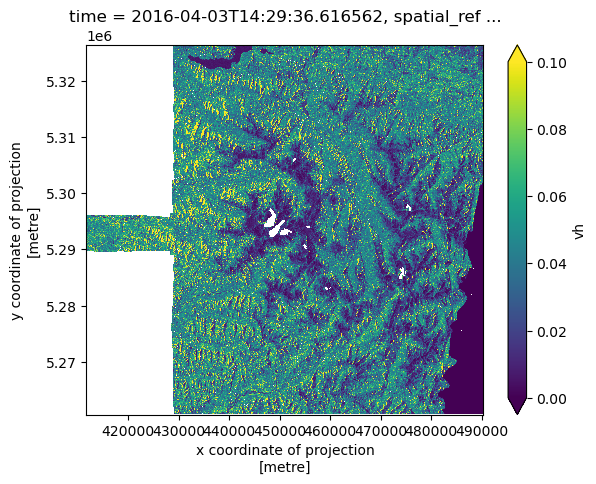

In [38]:
rtc_ds.vh.plot(vmax=0.1, vmin=0)

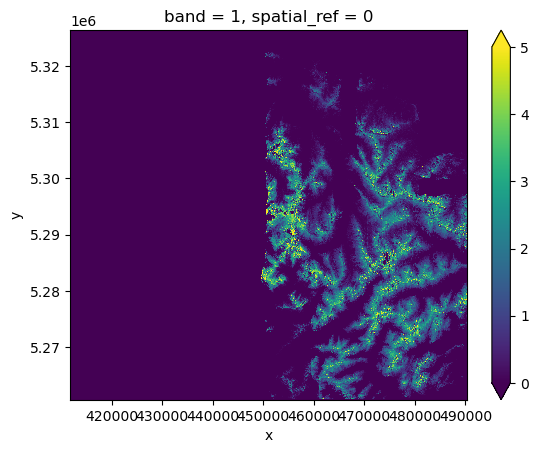

In [34]:
aso.plot(vmin=0, vmax=5)